<a href="https://colab.research.google.com/github/Long-Live-Lord-Voldemort/Long-Live-Lord-Voldemort/blob/main/AlgoTrading_MACD_RSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install yfinance

Technical Analysis Library for Calculations

In [18]:
pip install ta

In [19]:
import yfinance as yf
import numpy as np
import ta

In [20]:
df = yf.download('EURUSD=X', start='2021-12-01', interval='30m')

[*********************100%***********************]  1 of 1 completed


In [21]:
df['%K'] = ta.momentum.stoch(df.High, df.Low, df.Close, window=14, smooth_window=3)

In [22]:
df['%D'] = df['%K'].rolling(3).mean()

In [24]:
df['rsi'] = ta.momentum.rsi(df.Close, window=14)

In [25]:
df['macd'] = ta.trend.macd_diff(df.Close)

In [26]:
df.dropna(inplace=True)

In [27]:
import pandas as pd

In [28]:
dfx = pd.DataFrame()
for i in range(1, 4):
  mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20)
  dfx = dfx.append(mask, ignore_index=True)

In [29]:
dfx

,2021-12-01 16:30:00+00:00,2021-12-01 17:00:00+00:00,2021-12-01 17:30:00+00:00,2021-12-01 18:00:00+00:00,2021-12-01 18:30:00+00:00,2021-12-01 19:00:00+00:00,2021-12-01 19:30:00+00:00,2021-12-01 20:00:00+00:00,2021-12-01 20:30:00+00:00,2021-12-01 21:00:00+00:00,2021-12-01 21:30:00+00:00,2021-12-01 22:00:00+00:00,2021-12-01 22:30:00+00:00,2021-12-01 23:00:00+00:00,2021-12-01 23:30:00+00:00,2021-12-02 00:00:00+00:00,2021-12-02 00:30:00+00:00,2021-12-02 01:00:00+00:00,2021-12-02 01:30:00+00:00,2021-12-02 02:00:00+00:00,2021-12-02 02:30:00+00:00,2021-12-02 03:00:00+00:00,2021-12-02 03:30:00+00:00,2021-12-02 04:00:00+00:00,2021-12-02 04:30:00+00:00,2021-12-02 05:00:00+00:00,2021-12-02 05:30:00+00:00,2021-12-02 06:00:00+00:00,2021-12-02 06:30:00+00:00,2021-12-02 07:00:00+00:00,2021-12-02 07:30:00+00:00,2021-12-02 08:00:00+00:00,2021-12-02 08:30:00+00:00,2021-12-02 09:00:00+00:00,2021-12-02 09:30:00+00:00,2021-12-02 10:00:00+00:00,2021-12-02 10:30:00+00:00,2021-12-02 11:00:00+00:00,2021-12-02 11:30:00+00:00,2021-12-02 12:00:00+00:00,...,2022-01-19 12:00:00+00:00,2022-01-19 12:30:00+00:00,2022-01-19 13:00:00+00:00,2022-01-19 13:30:00+00:00,2022-01-19 14:00:00+00:00,2022-01-19 14:30:00+00:00,2022-01-19 15:00:00+00:00,2022-01-19 15:30:00+00:00,2022-01-19 16:00:00+00:00,2022-01-19 16:30:00+00:00,2022-01-19 17:00:00+00:00,2022-01-19 17:30:00+00:00,2022-01-19 18:00:00+00:00,2022-01-19 18:30:00+00:00,2022-01-19 19:00:00+00:00,2022-01-19 19:30:00+00:00,2022-01-19 20:00:00+00:00,2022-01-19 20:30:00+00:00,2022-01-19 21:00:00+00:00,2022-01-19 21:30:00+00:00,2022-01-19 22:00:00+00:00,2022-01-19 22:30:00+00:00,2022-01-19 23:00:00+00:00,2022-01-19 23:30:00+00:00,2022-01-20 00:00:00+00:00,2022-01-20 00:30:00+00:00,2022-01-20 01:00:00+00:00,2022-01-20 01:30:00+00:00,2022-01-20 02:00:00+00:00,2022-01-20 02:30:00+00:00,2022-01-20 03:00:00+00:00,2022-01-20 03:30:00+00:00,2022-01-20 04:00:00+00:00,2022-01-20 04:30:00+00:00,2022-01-20 05:00:00+00:00,2022-01-20 05:30:00+00:00,2022-01-20 06:00:00+00:00,2022-01-20 06:30:00+00:00,2022-01-20 07:00:00+00:00,2022-01-20 07:30:00+00:00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
def gettriggers(df, lags, buy=True):
  dfx = pd.DataFrame()
  for i in range(1, lags+1):
    if buy:
      mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) <20)
    else: 
      mask = (df['%K'].shift(i) > 80) & (df['%D'].shift(i) >80)
    dfx = dfx.append(mask, ignore_index=True)
  return dfx.sum(axis=0)

In [32]:
df['Buytrigger'] = np.where(gettriggers(df, 4), 1,0)

In [33]:
df['Selltrigger'] = np.where(gettriggers(df, 4, False), 1,0)

In [36]:
df['Buy'] = np.where((df.Buytrigger) & (df['%K'].between(20,80)) & (df['%D'].between(20,80)) & (df.rsi > 50) & (df.macd > 0), 1, 0)

In [38]:
df['Sell'] = np.where((df.Selltrigger) & (df['%K'].between(20,80)) & (df['%D'].between(20,80)) & (df.rsi < 50) & (df.macd < 0), 1, 0)

In [39]:
Buying_dates, Selling_dates = [], []

In [42]:
for i in range(len(df) - 1):
  if df.Buy.iloc[i]:
    Buying_dates.append(df.iloc[i + 1].name)
    for num, j in enumerate(df.Sell[i:]):
      if j:
        Selling_dates.append(df.iloc[i+ num + 1].name)
        break

In [43]:
cutit = len(Buying_dates) - len(Selling_dates)

In [44]:
if cutit:
  Buying_dates = Buying_dates[:-cutit]

In [45]:
frame = pd.DataFrame({'Buying_dates':Buying_dates, 'Selling_dates':Selling_dates})

In [51]:
frame

,Buying_dates,Selling_dates
0,2021-12-02 10:30:00+00:00,2021-12-16 16:00:00+00:00
1,2021-12-03 08:30:00+00:00,2021-12-16 16:00:00+00:00
2,2021-12-03 17:30:00+00:00,2021-12-16 16:00:00+00:00
3,2021-12-03 18:00:00+00:00,2021-12-16 16:00:00+00:00
4,2021-12-10 14:00:00+00:00,2021-12-16 16:00:00+00:00
5,2021-12-27 11:30:00+00:00,2021-12-28 14:00:00+00:00
6,2021-12-29 12:00:00+00:00,2022-01-05 19:30:00+00:00
7,2021-12-30 12:00:00+00:00,2022-01-05 19:30:00+00:00
8,2021-12-31 10:00:00+00:00,2022-01-05 19:30:00+00:00
9,2022-01-04 09:30:00+00:00,2022-01-05 19:30:00+00:00


In [49]:
actuals = frame[frame.Buying_dates > frame.Selling_dates.shift(1)]

In [52]:
actuals

,Buying_dates,Selling_dates
5,2021-12-27 11:30:00+00:00,2021-12-28 14:00:00+00:00
6,2021-12-29 12:00:00+00:00,2022-01-05 19:30:00+00:00
11,2022-01-10 16:30:00+00:00,2022-01-14 07:30:00+00:00


In [60]:
def profitcalc():
  Buyprices = df.loc[actuals.Buying_dates].Open
  Sellprices = df.loc[actuals.Selling_dates].Open
  return (Sellprices.values - Buyprices.values)/Buyprices.values

In [61]:
profits = profitcalc()

In [62]:
profits

array([0.00022647, 0.0016984 , 0.01215602])

In [63]:
profits.mean()

0.004693629113662441

In [64]:
(profits + 1).prod()

1.0141046753962606

In [69]:
import matplotlib.pyplot as plt

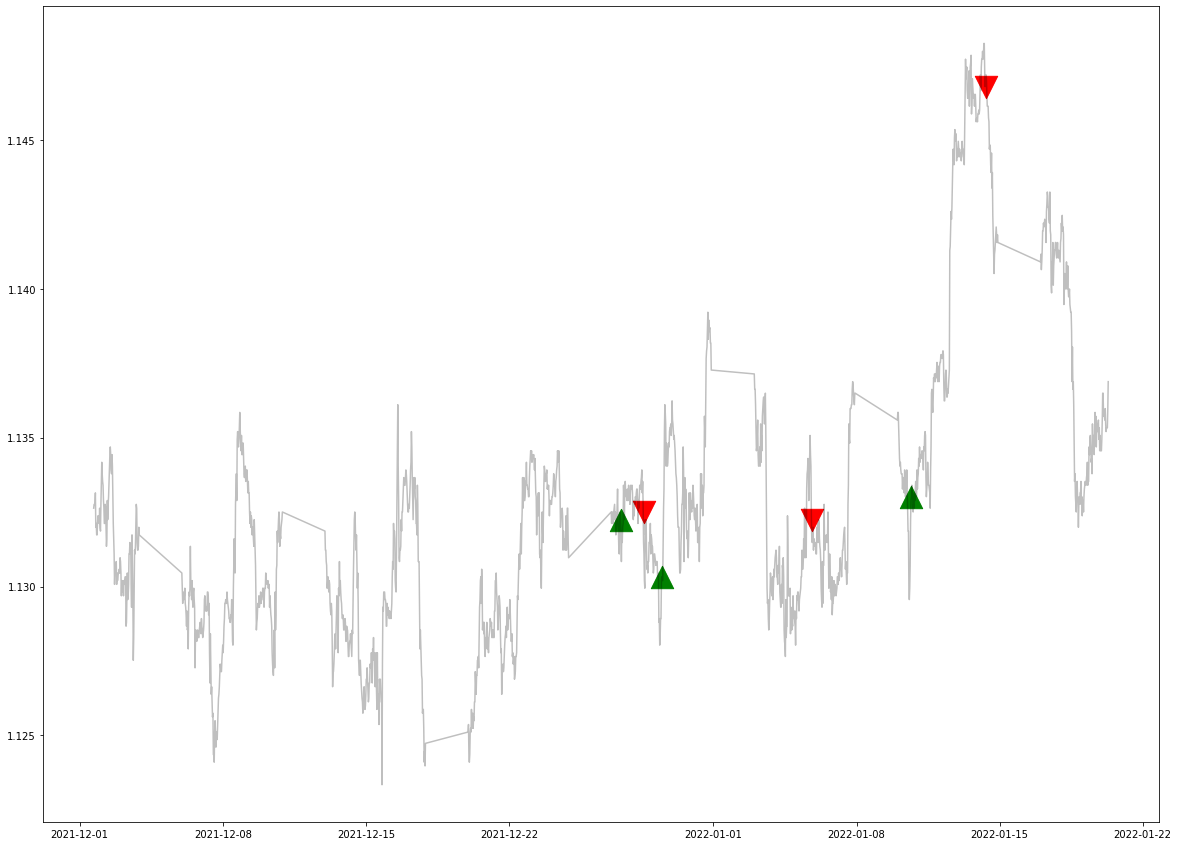

In [70]:
plt.figure(figsize=(20,15))
plt.plot(df.Close, color='k', alpha=0.25)
plt.scatter(actuals.Buying_dates, df.Open[actuals.Buying_dates], marker='^', color='g', s=500)
plt.scatter(actuals.Selling_dates, df.Open[actuals.Selling_dates], marker='v', color='r', s=500)